In [1]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path
from   desimodel.focalplane  import get_tile_radius_deg

In [2]:
np.random.seed(seed=314)

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [8]:
def get_clauds(field='COSMOS', release='February2021'):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    if release == 'October2020':
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v3_v201026.fits'.format(release, field))

    else:
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v9_v210212.fits'.format(release, field))

    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    clauds[field]    = clauds[field][(clauds[field]['MASK'] == 0)] 
    
    # u or uS data.
    inband           = (clauds[field]['FLAG_FIELD_BINARY'][:,1] == True) | (clauds[field]['FLAG_FIELD_BINARY'][:,2] == True)              

    clauds[field]    = clauds[field][inband]               

    # Randomise the rows for security. 
    indices          = np.arange(len(clauds[field]))
    randomised       = np.random.choice(indices, size=len(indices), replace=False)
    
    return  clauds[field][randomised], areas[field]

In [4]:
def cor_ustar(clauds):
    a             =  0.11213993918965293
    b             = -0.014060976414076887
        
    clauds['uSc'] = clauds['uS'] + a * (clauds['g'] - clauds['r']) + b

In [5]:
def combine_u(clauds):
    # combine u and u star
    u_comb     = np.zeros(len(clauds))
    u_comb_err = np.zeros(len(clauds))

    u1         = clauds['u']
    u1_err     = clauds['u_err']
     
    # NOTE: not correcting the error for the S transform. 
    u2         = clauds['uSc']
    u2_err     = clauds['uS_err']
        
    nfails     = 0
        
    for i in range (len(u_comb)):
        if   (u1_err[i]<0.0 and u2_err[i]>0.0):
            u_comb[i]     = u2[i]
            u_comb_err[i] = u2_err[i]
                    
        elif (u1_err[i]>0.0 and u2_err[i]<0.0):
            u_comb[i]     = u1[i]
            u_comb_err[i] = u1_err[i]
                
        elif (u1_err[i]>0.0 and u2_err[i]>0.0):
            w_u           = u1_err[i]**(-2.0)/ (u1_err[i]**(-2.0) + u2_err[i]**(-2.0))
            w_u2          = u2_err[i]**(-2.0)/ (u1_err[i]**(-2.0) + u2_err[i]**(-2.0))
                
            u_comb[i]     = w_u*u1[i] +  w_u2* u2[i]
            u_comb_err[i] = (u1_err[i]**(-2.0) + u2_err[i]**(-2.0))**(-1./2.)

        elif (u1_err[i]<0.0 and u2_err[i]<0.0):
            u_comb[i]     = -99
            u_comb_err[i] = -99

        else:            
            u_comb[i]     = -99
            u_comb_err[i] = -99            
            
            nfails       +=   1 

    print('Number of failuers: {}'.format(nfails))

    clauds['uW']     = u_comb
    clauds['uW_err'] = u_comb_err

In [76]:
def select_tomog(clauds, components=False):
    # Quality cuts
    quality = (clauds['uW_err'] > 0.0) & (clauds['uW_err'] < 10.0) & (clauds['uW'] > 0.0) & (clauds['g'] > 0.0) & (clauds['r'] > 0.0) 
    quality = quality & (clauds['g_err'] > 0.0) & (clauds['r_err'] > 0.0)

    umg     = clauds['u'] - clauds['g']
    gmr     = clauds['g'] - clauds['r']
    
    # ---  Color boxes  ---
    # Original
    # color_box     = (umg>0.9) & (gmr<1.2) & (umg>1.5*gmr+0.75)
    color_box       = (umg>0.88) & (gmr<1.2) & (umg>1.99*gmr+0.68)
    
    color_box_ext_1 = (umg>0.4) & (umg<1.0) & (umg>2.4*gmr+0.3) & (gmr<0.15) & ~color_box
    color_box_ext_2 = (umg>0.7) & (umg<1.5) & (umg>2.4*gmr+0.3) & ~color_box & ~color_box_ext_1
    
    # r mag.
    r_range         = (clauds['r']>22.5) & (clauds['r']<24.5) & quality & (gmr>-0.5)

    # final selection
    sel_LBG       = color_box & r_range & (clauds['r_err'] < 0.4)
    
    sel_LBG_ext_1 = color_box_ext_1 & r_range & (clauds['r_err'] < 0.4)
    sel_LBG_ext_2 = color_box_ext_2 & r_range & (clauds['r_err'] < 0.4)
    
    sel           = sel_LBG | sel_LBG_ext_1 | sel_LBG_ext_2
    
    if not components:
        return clauds[sel]
    
    else:
        return clauds[sel_LBG], clauds[sel_LBG_ext_1], clauds[sel_LBG_ext_2]

In [77]:
tile_radius  = get_tile_radius_deg()
tiles        = Table(io.load_tiles())

In [78]:
clauds, area = get_clauds(field='COSMOS', release='October2020')

In [79]:
print(len(clauds) / 1.e6)

3.153759


In [80]:
cor_ustar(clauds)

Text(0, 0.5, '(uSc / uS) - 1')

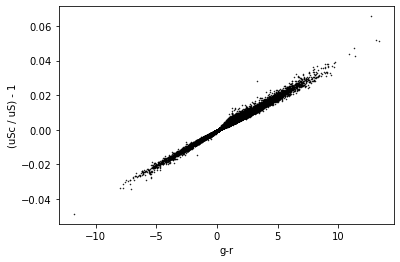

In [81]:
cut = (clauds['uS'] > 0.0) & (clauds['g'] > 0.0) & (clauds['r'] > 0.0)

pl.plot(clauds['g'][cut] - clauds['r'][cut], (clauds['uSc'][cut] / clauds['uS'][cut]) - 1.0, marker='.', lw=0.0, markersize=1, c='k')

pl.xlabel('g-r')
pl.ylabel('(uSc / uS) - 1')

In [82]:
combine_u(clauds)

Number of failuers: 438


In [83]:
tomog = select_tomog(clauds, components=False)

In [84]:
print(len(tomog) / 1.e4)

2.5559


In [85]:
tomog_lbg, tomog_lbg1, tomog_lbg2 = select_tomog(clauds, components=True)

In [86]:
print(len(tomog_lbg) / 1.e4, len(tomog_lbg1) / 1.e4, len(tomog_lbg2) / 1.e4)

1.9656 0.2379 0.3524


In [87]:
# Old length: 2582606
tomog

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,uSc,uW,uW_err
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
3001152,148.95002016977335,2.5687170094760186,9812,"3,6",0,5,True .. False,0.00020946888,0.00017379351,4.0,-23.779047,1.2052313,0.17028373,0.028586670062718388,0.00033285245,23.087433,0.1494670957326889,1.370134,2.0168593,2.5981574,25.017,23.221,23.073,22.876,22.645,22.071,22.043,-99.035,-99.025,-99.016,-99.01,1000.0,0.023,0.011,0.013,0.014,0.012,0.029,-99.0,-99.0,-99.0,-99.0,27.02449,23.72471,23.572388,23.30329,23.044537,22.465582,22.493849,1e+20,1e+20,1e+20,1e+20,691226270000000.0,0.014919427,0.0071229236,0.0083593475,0.008878192,0.0077319224,0.019638682,1e+20,1e+20,1e+20,1e+20,127.0,-20.484,-20.69,-21.304,-21.419,-21.731,-21.894,-22.039,-22.176,-22.243,-22.255,-22.274,-22.381,-22.172,-99.0,1.1791,1.1394,1.2882,7,7.58684,597.763,6.40196,31,60,29,1.2061,1.1541,1.3123,-99.0,0.4,11,286119000.0,0.2,1,367297000.0,9.93699,9.95594,9.86299,9.99609,1.46295,1.42415,1.35647,1.57263,-8.50041,-8.53179,-8.58652,-8.40741,10.3611,10.0637,9.07673,0.0,0,1.2061,23.229030591606286,23.22903059255212,0.022999999993916498
1599904,150.03079525085303,1.4974391558163422,9570,"2,8",0,7,True .. False,0.00023009388,0.0001538775,4.0,-41.3618,1.4951341,0.33116364,0.017383782409194855,0.00057117624,24.641117,0.11876534670591354,1.3194618,2.0002446,2.5867515,25.156,25.159,24.524,24.463,24.212,23.868,23.89,-99.021,-99.015,-99.01,-99.006,0.047,0.047,0.023,0.028,0.026,0.03,0.06,-99.0,-99.0,-99.0,-99.0,25.697052,25.647642,25.063307,24.87989,24.69748,24.410892,24.396692,1e+20,1e+20,1e+20,1e+20,0.03459902,0.033456538,0.017426182,0.019064426,0.018906802,0.023592548,0.045231745,1e+20,1e+20,1e+20,1e+20,127.0,-20.325,-20.607,-21.503,-21.737,-22.466,-22.893,-23.184,-23.366,-23.453,-23.479,-23.561,-23.732,-23.515,-99.0,2.1149,2.0735,2.1599,7,2.69546,93.6798,5.40871,33,49,29,2.1046,2.0479,2.1537,-99.0,0.74,3,1800000000.0,0.2,1,921710000.0,10.5449,10.8129,10.1699,10.

In [88]:
print('Target density of tomog galaxies per sq. deg. is {:.2f}'.format(len(tomog) / area['u']))

Target density of tomog galaxies per sq. deg. is 5795.69


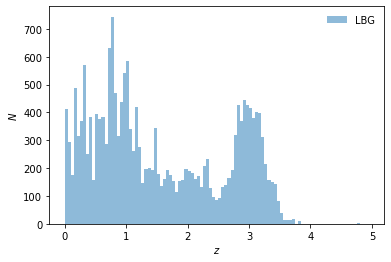

In [89]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog_lbg['Z_BEST'], bins=bins, alpha=0.5, label='LBG')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [101]:
print(100. * np.count_nonzero(tomog_lbg['Z_BEST'] < 1.5) / len(tomog_lbg))

55.75905575905576


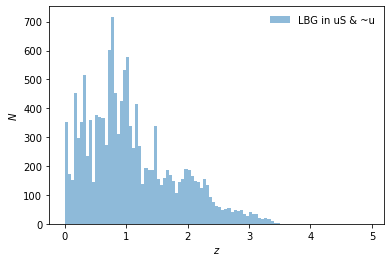

In [107]:
bins = np.arange(0.0, 5.0, 0.05)

# uS and not u 
cut  = (tomog_lbg['FLAG_FIELD_BINARY'][:,2] == True) & (tomog_lbg['FLAG_FIELD_BINARY'][:,1] == False)

pl.hist(tomog_lbg['Z_BEST'][cut], bins=bins, alpha=0.5, label='LBG in uS & ~u')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [105]:
print(100. * np.count_nonzero(tomog_lbg[cut]['Z_BEST'] < 1.5) / len(tomog_lbg[cut]))

74.81037347395795


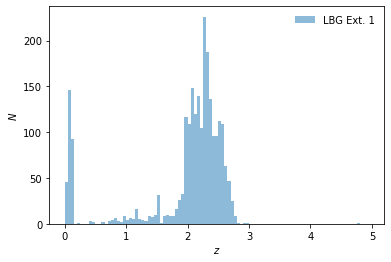

In [91]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog_lbg1['Z_BEST'], bins=bins, alpha=0.5, label='LBG Ext. 1')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [92]:
print(len(tomog_lbg1), np.count_nonzero(tomog_lbg1['Z_BEST'] < 1.5))

2379 387


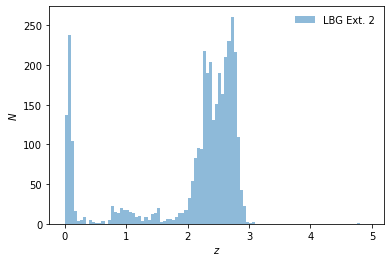

In [93]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog_lbg2['Z_BEST'], bins=bins, alpha=0.5, label='LBG Ext. 2')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [94]:
print(len(tomog_lbg2), np.count_nonzero(tomog_lbg2['Z_BEST'] < 1.5))

3524 725


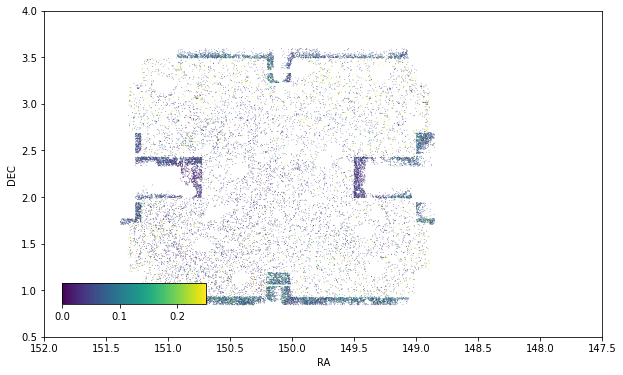

In [95]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(tomog['RA'], tomog['DEC'], c=tomog['uW_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)
        
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

pl.savefig('plots/clauds_tomog_field.pdf')

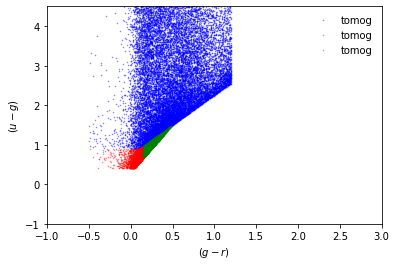

In [51]:
pl.plot(tomog_lbg['g']  - tomog_lbg['r'],  tomog_lbg['u']  - tomog_lbg['g'],  marker='.', c='b', lw=0.0, label='tomog', alpha=0.5, markersize=1)
pl.plot(tomog_lbg1['g'] - tomog_lbg1['r'], tomog_lbg1['u'] - tomog_lbg1['g'], marker='.', c='r', lw=0.0, label='tomog', alpha=0.5, markersize=1)
pl.plot(tomog_lbg2['g'] - tomog_lbg2['r'], tomog_lbg2['u'] - tomog_lbg2['g'], marker='.', c='g', lw=0.0, label='tomog', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-tomog-selection.pdf')

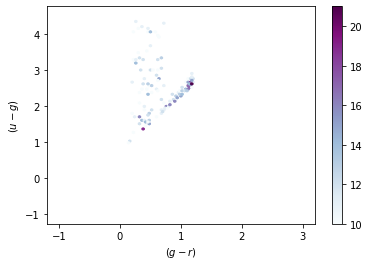

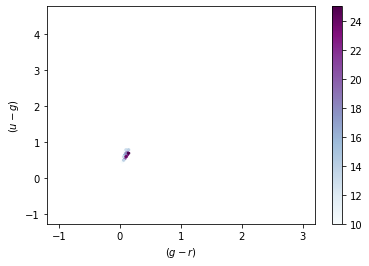

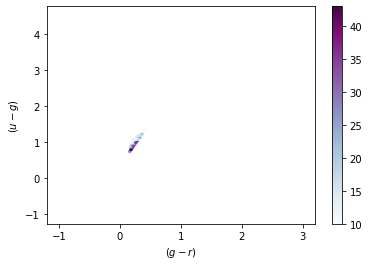

In [71]:
zmax = 1.5

for tt in [tomog_lbg, tomog_lbg1, tomog_lbg2]:
    interloper = tt[tt['Z_BEST'] < zmax]
    highz      = tt[tt['Z_BEST'] > zmax]

    plt.hexbin(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], extent=[-1., 3., -1., 4.5], cmap='BuPu', mincnt=10.0)
    pl.colorbar()

    pl.xlabel(r'$(g-r)$')
    pl.ylabel(r'$(u-g)$')
    pl.show()

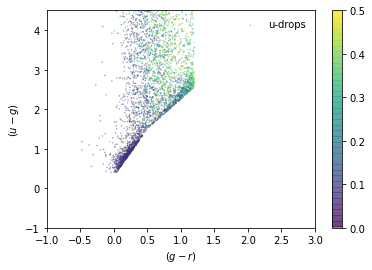

In [62]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

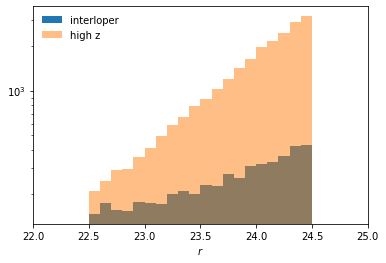

In [61]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.xlim(22., 25.)

pl.yscale('log')
pl.xlabel(r'$r$')

pl.legend(frameon=False)

# Done.